In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize
import cv2
from tqdm import tqdm

In [ ]:
class ImageDerainingDataset:
    def __init__(self, rainy_dir, clean_dir, img_size=(256, 256)):
        self.rainy_dir = rainy_dir
        self.clean_dir = clean_dir
        self.img_size = img_size
        self.rainy_images = sorted(os.listdir(rainy_dir))
        self.clean_images = sorted(os.listdir(clean_dir))

        # Verify that the images are paired
        assert len(self.rainy_images) == len(self.clean_images), "Number of rainy and clean images must match"
        for r, c in zip(self.rainy_images, self.clean_images):
            assert r == c, f"Image pairs must match: {r} vs {c}"

    def __len__(self):
        return len(self.rainy_images)

    def preprocess_image(self, image_path):
        """Load and preprocess image (resize to 256x256 and normalize)"""
        # Load image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize to target dimensions
        img = cv2.resize(img, self.img_size, interpolation=cv2.INTER_AREA)

        # Normalize to [-1, 1]
        img = (img - 127.5) / 127.5

        return img.astype(np.float32)

    def __getitem__(self, idx):
        rainy_path = os.path.join(self.rainy_dir, self.rainy_images[idx])
        clean_path = os.path.join(self.clean_dir, self.clean_images[idx])

        rainy_img = self.preprocess_image(rainy_path)
        clean_img = self.preprocess_image(clean_path)

        return rainy_img, clean_img

    def create_dataset(self, batch_size=1, shuffle=True):
        rainy_imgs = []
        clean_imgs = []

        print("Loading and preprocessing images...")
        for i in tqdm(range(len(self))):
            r, c = self[i]
            rainy_imgs.append(r)
            clean_imgs.append(c)

        rainy_imgs = np.array(rainy_imgs)
        clean_imgs = np.array(clean_imgs)

        dataset = tf.data.Dataset.from_tensor_slices((rainy_imgs, clean_imgs))
        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(self))
        dataset = dataset.batch(batch_size)

        return dataset

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        layers.Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(layers.BatchNormalization())

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        layers.Conv2DTranspose(filters, size, strides=2,
                               padding='same',
                               kernel_initializer=initializer,
                               use_bias=False))

    result.add(layers.BatchNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])

    # Downsampling
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    # Upsampling
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)




In [ ]:
    generator = build_generator()
    print("\nGenerator Summary:")
    generator.summary()


Generator Summary:


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 128, 128, 64)   │          3,072 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 64, 64, 128)    │        131,584 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 32, 32, 256)    │        525,312 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 16, 16, 512)    │      2,099,200 │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 8, 8, 512)      │      4,196,352 │ sequential_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_5 (Sequential) │ (None, 4, 4, 512)      │      4,196,352 │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_6 (Sequential) │ (None, 2, 2, 512)      │      4,196,352 │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_7 (Sequential) │ (None, 1, 1, 512)      │      4,196,352 │ sequential_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_8 (Sequential) │ (None, 2, 2, 512)      │      4,196,352 │ sequential_7[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2, 2, 1024)     │              0 │ sequential_8[0][0],    │
│                           │                        │                │ sequential_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_9 (Sequential) │ (None, 4, 4, 512)      │      8,390,656 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 4, 4, 1024)     │              0 │ sequential_9[0][0],    │
│ (Concatenate)             │                        │                │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_10             │ (None, 8, 8, 512)      │      8,390,656 │ concatenate_1[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 8, 8, 1024)     │              0 │ sequential_10[0][0],   │
│ (Concatenate)             │                        │                │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_11             │ (None, 16, 16, 512)    │      8,390,656 │ concatenate_2[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 16, 16, 1024)   │              0 │ sequential_11[0][0],   │
│ (Concatenate)        

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [ ]:
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    tar = layers.Input(shape=[256, 256, 3], name='target_image')

    x = layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = layers.BatchNormalization()(conv)

    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
discriminator = build_discriminator()
print("\nDiscriminator Summary:")
discriminator.summary()



Discriminator Summary:


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_image (InputLayer) │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 256, 256, 6)    │              0 │ input_image[0][0],     │
│ (Concatenate)             │                        │                │ target_image[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_15             │ (None, 128, 128, 64)   │          6,144 │ concatenate_7[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_16             │ (None, 64, 64, 128)    │        131,584 │ sequential_15[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_17             │ (None, 32, 32, 256)    │        525,312 │ sequential_16[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 34, 34, 256)    │              0 │ sequential_17[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 31, 31, 512)    │      2,097,152 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 31, 31, 512)    │          2,048 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_11            │ (None, 31, 31, 512)    │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 33, 33, 512)    │              0 │ leaky_re_lu_11[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 30, 30, 1)      │          8,193 │ zero_padding2d_1[0][0] │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
LAMBDA = 50

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [ ]:
def calculate_psnr(original, generated):
    """Calculate PSNR between original and generated images"""
    # Convert from [-1, 1] to [0, 255]
    original = (original * 127.5 + 127.5).astype(np.uint8)
    generated = (generated * 127.5 + 127.5).astype(np.uint8)

    # Calculate PSNR for each channel and average
    psnr_values = []
    for i in range(3):  # For each RGB channel
        psnr_values.append(psnr(original[:,:,i], generated[:,:,i], data_range=255))
    return np.mean(psnr_values)

def calculate_ssim(original, generated):
    """Calculate SSIM between original and generated images"""
    # Convert from [-1, 1] to [0, 255]
    original = (original * 127.5 + 127.5).astype(np.uint8)
    generated = (generated * 127.5 + 127.5).astype(np.uint8)

    # SSIM calculation (multichannel=True for color images)
    return ssim(original, generated, multichannel=True, data_range=255, channel_axis=2)

def evaluate_model(generator, dataset, num_samples=5):
    """Evaluate model on a dataset and calculate PSNR/SSIM metrics"""
    psnr_values = []
    ssim_values = []

    for rainy, clean in dataset.take(num_samples):
        generated = generator(rainy, training=False)

        # Convert tensors to numpy arrays
        clean_np = clean[0].numpy()
        generated_np = generated[0].numpy()

        # Calculate metrics
        psnr_values.append(calculate_psnr(clean_np, generated_np))
        ssim_values.append(calculate_ssim(clean_np, generated_np))

    return np.mean(psnr_values), np.mean(ssim_values)

In [ ]:
#main
class CGAN:
    def __init__(self, generator, discriminator):
        self.generator = generator
        self.discriminator = discriminator
        self.generator_optimizer = optimizers.Adam(1e-4, beta_1=0.5,clipvalue=1.0)
        self.discriminator_optimizer = optimizers.Adam(1e-4, beta_1=0.5,clipvalue=1.0)

        # Metrics tracking
        self.gen_loss_metric = tf.keras.metrics.Mean(name='gen_loss')
        self.disc_loss_metric = tf.keras.metrics.Mean(name='disc_loss')
        self.psnr_metric = tf.keras.metrics.Mean(name='psnr')
        self.ssim_metric = tf.keras.metrics.Mean(name='ssim')

        # Checkpointing
        self.checkpoint_dir = './training_checkpoints'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(
            generator_optimizer=self.generator_optimizer,
            discriminator_optimizer=self.discriminator_optimizer,
            generator=self.generator,
            discriminator=self.discriminator)

    @tf.function
    def train_step(self, input_image, target):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_output = self.generator(input_image, training=True)

            disc_real_output = self.discriminator([input_image, target], training=True)
            disc_generated_output = self.discriminator([input_image, gen_output], training=True)

            gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
                disc_generated_output, gen_output, target)
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(
            gen_total_loss, self.generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(
            disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(
            zip(generator_gradients, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(
            zip(discriminator_gradients, self.discriminator.trainable_variables))

        # Update metrics
        self.gen_loss_metric.update_state(gen_total_loss)
        self.disc_loss_metric.update_state(disc_loss)

        return gen_total_loss, disc_loss

    def plot_training_metrics(self, history, save_path="training_metrics.png"):
        """
        Plots Generator Loss, Discriminator Loss, PSNR, and SSIM across epochs
        Args:
            history: Dictionary containing metric lists
                   {'gen_loss': [], 'disc_loss': [], 'psnr': [], 'ssim': []}
            save_path: Path to save the plot image
        """
        plt.figure(figsize=(15, 10))

        # Plot Generator and Discriminator Loss
        plt.subplot(2, 2, 1)
        plt.plot(history['gen_loss'], label='Generator Loss')
        plt.plot(history['disc_loss'], label='Discriminator Loss')
        plt.title('Training Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # PSNR and SSIM
        plt.subplot(2, 2, 4)
        plt.plot(history['psnr'], 'g-', label='PSNR')
        plt.plot(history['ssim'], 'r-', label='SSIM')
        plt.title('Quality Metrics')
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()

    def train(self, train_dataset, val_dataset, epochs):
        # summary writer for TensorBoard
        train_log_dir = 'logs/train'
        val_log_dir = 'logs/val'
        train_summary_writer = tf.summary.create_file_writer(train_log_dir)
        val_summary_writer = tf.summary.create_file_writer(val_log_dir)

        # Initialize history dictionary
        history = {
            'gen_loss': [],
            'disc_loss': [],
            'psnr': [],
            'ssim': []
        }

        for epoch in range(epochs):

            # self.gen_loss_metric = tf.keras.metrics.Mean(name='gen_loss')
            # self.disc_loss_metric = tf.keras.metrics.Mean(name='disc_loss')
            # self.psnr_metric = tf.keras.metrics.Mean(name='psnr')
            # self.ssim_metric = tf.keras.metrics.Mean(name='ssim')

            # Training loop
            for n, (input_image, target) in tqdm(enumerate(train_dataset), total=len(train_dataset)):
                self.train_step(input_image, target)

            # Save model every 10 epochs
            if (epoch + 1) % 10 == 0:
                  self.save_model(f"my_deraining_model_epoch_{epoch+1}")

            # Validation metrics
            val_psnr, val_ssim = evaluate_model(self.generator, val_dataset)
            self.psnr_metric.update_state(val_psnr)
            self.ssim_metric.update_state(val_ssim)

            # Print metrics
            template = 'Epoch {}, Gen Loss: {:.4f}, Disc Loss: {:.4f}, PSNR: {:.2f}, SSIM: {:.4f}'
            print(template.format(
                epoch + 1,
                self.gen_loss_metric.result(),
                self.disc_loss_metric.result(),
                self.psnr_metric.result(),
                self.ssim_metric.result()))

            # Write to TensorBoard
            with train_summary_writer.as_default():
                tf.summary.scalar('gen_loss', self.gen_loss_metric.result(),step=epoch)
                tf.summary.scalar('disc_loss', self.disc_loss_metric.result(),step=epoch)

            with val_summary_writer.as_default():
                tf.summary.scalar('psnr', self.psnr_metric.result(), step=epoch)
                tf.summary.scalar('ssim', self.ssim_metric.result(), step=epoch)

            # Save checkpoint every 5 epochs
            if (epoch + 1) % 5 == 0:
                self.checkpoint.save(file_prefix=self.checkpoint_prefix)

            # Generate sample images every epoch
            self.generate_images(train_dataset.take(1), epoch + 1)

            # Store metrics after each epoch
            history['gen_loss'].append(float(self.gen_loss_metric.result()))
            history['disc_loss'].append(float(self.disc_loss_metric.result()))
            history['psnr'].append(float(self.psnr_metric.result()))
            history['ssim'].append(float(self.ssim_metric.result()))

        self.plot_training_metrics(history)  # Generate plots
        return history  # Return metrics for analysis


    def generate_images(self, test_dataset, epoch):
        for example_input, example_target in test_dataset:
            prediction = self.generator(example_input, training=False)

            plt.figure(figsize=(15, 5))

            display_list = [example_input[0], example_target[0], prediction[0]]
            title = ['Input Image', 'Ground Truth', 'Predicted Image']

            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.title(title[i])
                # Convert from [-1, 1] to [0, 1] for display
                plt.imshow(display_list[i] * 0.5 + 0.5)
                plt.axis('off')

            # Save the generated images
            os.makedirs('training_results', exist_ok=True)
            plt.savefig(f'training_results/image_at_epoch_{epoch:04d}.png')
            plt.close()

            # Calculate and print metrics for this sample
            clean_np = example_target[0].numpy()
            generated_np = prediction[0].numpy()
            sample_psnr = calculate_psnr(clean_np, generated_np)
            sample_ssim = calculate_ssim(clean_np, generated_np)
            #print(f'Sample PSNR: {sample_psnr:.2f}, SSIM: {sample_ssim:.4f}')


    def save_model(self, save_dir="saved_models"):
          """Save generator and discriminator models"""
          os.makedirs(save_dir, exist_ok=True)

          # Save generator
          generator_path = os.path.join(save_dir, "generator.keras")
          self.generator.save(generator_path)

          # Save discriminator (optional)
          discriminator_path = os.path.join(save_dir, "discriminator.keras")
          self.discriminator.save(discriminator_path)

          print(f"Models saved to {save_dir}")

    def load_model(self, save_dir="saved_models"):
        """Load saved models"""
        generator_path = os.path.join(save_dir, "generator")
        discriminator_path = os.path.join(save_dir, "discriminator")

        if os.path.exists(generator_path):
            self.generator = tf.keras.models.load_model(generator_path)
            print("Generator loaded successfully")

        if os.path.exists(discriminator_path):
            self.discriminator = tf.keras.models.load_model(discriminator_path)
            print("Discriminator loaded successfully")

    def test_single_image(self, image_path, output_path="derained_image.png"):
        """Process a single rainy image and save the derained result"""
        # Load and preprocess the image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        image = (image / 127.5) - 1  # Scaling from [0, 255] to [-1, 1]
        img = np.expand_dims(img, axis=0)  # Add batch dimension

        # Generate derained image
        derained = self.generator.predict(img)[0]

        # Convert back to 0-255 range
        derained = (derained * 127.5 + 127.5).astype(np.uint8)

        # Save the result
        cv2.imwrite(output_path, cv2.cvtColor(derained, cv2.COLOR_RGB2BGR))
        print(f"Derained image saved to {output_path}")

        # Display results
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Rainy Input")
        plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Derained Output")
        plt.imshow(derained)
        plt.axis('off')

        plt.show()


In [ ]:
# Parameters
BATCH_SIZE = 4
EPOCHS = 50
IMG_SIZE = (256, 256)

# Paths to your dataset
train_rainy_dir = "/content/drive/MyDrive/CGAN_dataset/Train/input"
train_clean_dir = "/content/drive/MyDrive/CGAN_dataset/Train/target"
val_rainy_dir = "/content/drive/MyDrive/CGAN_dataset/Validation/input"
val_clean_dir = "/content/drive/MyDrive/CGAN_dataset/Validation/target"

# Create datasets
print("Creating training dataset...")
train_dataset = ImageDerainingDataset(train_rainy_dir, train_clean_dir, IMG_SIZE)
train_ds = train_dataset.create_dataset(batch_size=BATCH_SIZE)

print("Creating validation dataset...")
val_dataset = ImageDerainingDataset(val_rainy_dir, val_clean_dir, IMG_SIZE)
val_ds = val_dataset.create_dataset(batch_size=1, shuffle=False)  # No shuffle for validation



Creating training dataset...
Loading and preprocessing images...


100%|██████████| 700/700 [00:16<00:00, 43.30it/s]


Creating validation dataset...
Loading and preprocessing images...


100%|██████████| 300/300 [00:05<00:00, 52.45it/s]


In [ ]:
generator = build_generator()
discriminator = build_discriminator()

# Train
print("\nStarting training...")
cgan = CGAN(generator, discriminator)
history = cgan.train(train_ds, val_ds, EPOCHS)

print("Best PSNR:", max(history['psnr']))
print("Best SSIM:", max(history['ssim']))


Starting training...


100%|██████████| 175/175 [00:47<00:00,  3.68it/s]


Epoch 1, Gen Loss: 9.6461, Disc Loss: 1.4325, PSNR: 14.96, SSIM: 0.2869


100%|██████████| 175/175 [00:36<00:00,  4.76it/s]


Epoch 2, Gen Loss: 8.4034, Disc Loss: 1.3906, PSNR: 16.51, SSIM: 0.3718


100%|██████████| 175/175 [00:36<00:00,  4.78it/s]


Epoch 3, Gen Loss: 7.8007, Disc Loss: 1.3666, PSNR: 17.82, SSIM: 0.4353


100%|██████████| 175/175 [00:36<00:00,  4.76it/s]


Epoch 4, Gen Loss: 7.4646, Disc Loss: 1.3431, PSNR: 18.74, SSIM: 0.4810


100%|██████████| 175/175 [00:36<00:00,  4.77it/s]


Epoch 5, Gen Loss: 7.2180, Disc Loss: 1.3274, PSNR: 19.19, SSIM: 0.5143


100%|██████████| 175/175 [00:36<00:00,  4.73it/s]


Epoch 6, Gen Loss: 7.0315, Disc Loss: 1.3158, PSNR: 19.63, SSIM: 0.5408


100%|██████████| 175/175 [00:36<00:00,  4.76it/s]


Epoch 7, Gen Loss: 6.8836, Disc Loss: 1.3063, PSNR: 20.00, SSIM: 0.5627


100%|██████████| 175/175 [00:36<00:00,  4.78it/s]


Epoch 8, Gen Loss: 6.7526, Disc Loss: 1.3011, PSNR: 20.26, SSIM: 0.5790


100%|██████████| 175/175 [00:36<00:00,  4.76it/s]


Epoch 9, Gen Loss: 6.6351, Disc Loss: 1.2935, PSNR: 20.55, SSIM: 0.5949


100%|██████████| 175/175 [00:36<00:00,  4.78it/s]


Models saved to my_deraining_model_epoch_10
Epoch 10, Gen Loss: 6.5288, Disc Loss: 1.2893, PSNR: 20.80, SSIM: 0.6104


100%|██████████| 175/175 [00:36<00:00,  4.74it/s]


Epoch 11, Gen Loss: 6.4299, Disc Loss: 1.2872, PSNR: 20.98, SSIM: 0.6242


100%|██████████| 175/175 [00:36<00:00,  4.77it/s]


Epoch 12, Gen Loss: 6.3466, Disc Loss: 1.2849, PSNR: 21.18, SSIM: 0.6355


100%|██████████| 175/175 [00:36<00:00,  4.77it/s]


Epoch 13, Gen Loss: 6.2676, Disc Loss: 1.2844, PSNR: 21.31, SSIM: 0.6458


100%|██████████| 175/175 [00:36<00:00,  4.76it/s]


Epoch 14, Gen Loss: 6.1889, Disc Loss: 1.2846, PSNR: 21.46, SSIM: 0.6557


100%|██████████| 175/175 [00:36<00:00,  4.78it/s]


Epoch 15, Gen Loss: 6.1209, Disc Loss: 1.2846, PSNR: 21.60, SSIM: 0.6646


100%|██████████| 175/175 [00:37<00:00,  4.73it/s]


Epoch 16, Gen Loss: 6.0538, Disc Loss: 1.2842, PSNR: 21.75, SSIM: 0.6730


100%|██████████| 175/175 [00:36<00:00,  4.77it/s]


Epoch 17, Gen Loss: 5.9895, Disc Loss: 1.2855, PSNR: 21.87, SSIM: 0.6800


100%|██████████| 175/175 [00:36<00:00,  4.78it/s]


Epoch 18, Gen Loss: 5.9277, Disc Loss: 1.2860, PSNR: 21.79, SSIM: 0.6833


100%|██████████| 175/175 [00:36<00:00,  4.74it/s]


Epoch 19, Gen Loss: 5.8700, Disc Loss: 1.2876, PSNR: 21.90, SSIM: 0.6883


100%|██████████| 175/175 [00:36<00:00,  4.78it/s]


Models saved to my_deraining_model_epoch_20
Epoch 20, Gen Loss: 5.8146, Disc Loss: 1.2890, PSNR: 21.99, SSIM: 0.6932


100%|██████████| 175/175 [00:37<00:00,  4.72it/s]


Epoch 21, Gen Loss: 5.7611, Disc Loss: 1.2905, PSNR: 22.09, SSIM: 0.6981


100%|██████████| 175/175 [00:36<00:00,  4.78it/s]


Epoch 22, Gen Loss: 5.7105, Disc Loss: 1.2918, PSNR: 22.20, SSIM: 0.7036


100%|██████████| 175/175 [00:36<00:00,  4.79it/s]


Epoch 23, Gen Loss: 5.6632, Disc Loss: 1.2928, PSNR: 22.26, SSIM: 0.7076


100%|██████████| 175/175 [00:36<00:00,  4.76it/s]


Epoch 24, Gen Loss: 5.6170, Disc Loss: 1.2943, PSNR: 22.33, SSIM: 0.7120


100%|██████████| 175/175 [00:36<00:00,  4.78it/s]


Epoch 25, Gen Loss: 5.5734, Disc Loss: 1.2955, PSNR: 22.40, SSIM: 0.7161


100%|██████████| 175/175 [00:37<00:00,  4.72it/s]


Epoch 26, Gen Loss: 5.5297, Disc Loss: 1.2969, PSNR: 22.47, SSIM: 0.7201


100%|██████████| 175/175 [00:36<00:00,  4.77it/s]


Epoch 27, Gen Loss: 5.4895, Disc Loss: 1.2981, PSNR: 22.52, SSIM: 0.7229


100%|██████████| 175/175 [00:36<00:00,  4.77it/s]


Epoch 28, Gen Loss: 5.4484, Disc Loss: 1.2988, PSNR: 22.59, SSIM: 0.7260


100%|██████████| 175/175 [00:36<00:00,  4.76it/s]


Epoch 29, Gen Loss: 5.4113, Disc Loss: 1.3001, PSNR: 22.64, SSIM: 0.7294


100%|██████████| 175/175 [00:36<00:00,  4.78it/s]


Models saved to my_deraining_model_epoch_30
Epoch 30, Gen Loss: 5.3726, Disc Loss: 1.3017, PSNR: 22.70, SSIM: 0.7320


100%|██████████| 175/175 [00:37<00:00,  4.72it/s]


Epoch 31, Gen Loss: 5.3364, Disc Loss: 1.3026, PSNR: 22.73, SSIM: 0.7337


100%|██████████| 175/175 [00:36<00:00,  4.78it/s]


Epoch 32, Gen Loss: 5.3022, Disc Loss: 1.3034, PSNR: 22.76, SSIM: 0.7362


100%|██████████| 175/175 [00:36<00:00,  4.79it/s]


Epoch 33, Gen Loss: 5.2672, Disc Loss: 1.3048, PSNR: 22.78, SSIM: 0.7380


100%|██████████| 175/175 [00:36<00:00,  4.76it/s]


Epoch 34, Gen Loss: 5.2349, Disc Loss: 1.3052, PSNR: 22.81, SSIM: 0.7402


100%|██████████| 175/175 [00:36<00:00,  4.78it/s]


Epoch 35, Gen Loss: 5.2028, Disc Loss: 1.3062, PSNR: 22.86, SSIM: 0.7423


100%|██████████| 175/175 [00:36<00:00,  4.76it/s]


Epoch 36, Gen Loss: 5.1734, Disc Loss: 1.3067, PSNR: 22.87, SSIM: 0.7432


100%|██████████| 175/175 [00:36<00:00,  4.77it/s]


Epoch 37, Gen Loss: 5.1432, Disc Loss: 1.3081, PSNR: 22.90, SSIM: 0.7454


100%|██████████| 175/175 [00:36<00:00,  4.78it/s]


Epoch 38, Gen Loss: 5.1139, Disc Loss: 1.3089, PSNR: 22.89, SSIM: 0.7458


100%|██████████| 175/175 [00:36<00:00,  4.77it/s]


Epoch 39, Gen Loss: 5.0848, Disc Loss: 1.3095, PSNR: 22.93, SSIM: 0.7479


100%|██████████| 175/175 [00:36<00:00,  4.77it/s]


Models saved to my_deraining_model_epoch_40
Epoch 40, Gen Loss: 5.0566, Disc Loss: 1.3100, PSNR: 22.96, SSIM: 0.7495


100%|██████████| 175/175 [00:36<00:00,  4.74it/s]


Epoch 41, Gen Loss: 5.0296, Disc Loss: 1.3110, PSNR: 22.98, SSIM: 0.7510


100%|██████████| 175/175 [00:36<00:00,  4.76it/s]


Epoch 42, Gen Loss: 5.0038, Disc Loss: 1.3115, PSNR: 23.00, SSIM: 0.7524


100%|██████████| 175/175 [00:36<00:00,  4.78it/s]


Epoch 43, Gen Loss: 4.9784, Disc Loss: 1.3123, PSNR: 23.02, SSIM: 0.7539


100%|██████████| 175/175 [00:36<00:00,  4.76it/s]


Epoch 44, Gen Loss: 4.9541, Disc Loss: 1.3127, PSNR: 23.04, SSIM: 0.7552


100%|██████████| 175/175 [00:36<00:00,  4.77it/s]


Epoch 45, Gen Loss: 4.9288, Disc Loss: 1.3135, PSNR: 23.06, SSIM: 0.7564


100%|██████████| 175/175 [00:37<00:00,  4.73it/s]


Epoch 46, Gen Loss: 4.9039, Disc Loss: 1.3141, PSNR: 23.09, SSIM: 0.7578


100%|██████████| 175/175 [00:36<00:00,  4.78it/s]


Epoch 47, Gen Loss: 4.8814, Disc Loss: 1.3144, PSNR: 23.11, SSIM: 0.7589


100%|██████████| 175/175 [00:36<00:00,  4.78it/s]


Epoch 48, Gen Loss: 4.8584, Disc Loss: 1.3150, PSNR: 23.13, SSIM: 0.7599


100%|██████████| 175/175 [00:36<00:00,  4.76it/s]


Epoch 49, Gen Loss: 4.8352, Disc Loss: 1.3156, PSNR: 23.15, SSIM: 0.7609


100%|██████████| 175/175 [00:36<00:00,  4.77it/s]


Models saved to my_deraining_model_epoch_50
Epoch 50, Gen Loss: 4.8126, Disc Loss: 1.3164, PSNR: 23.17, SSIM: 0.7620
Best PSNR: 23.17043685913086
Best SSIM: 0.7620059847831726


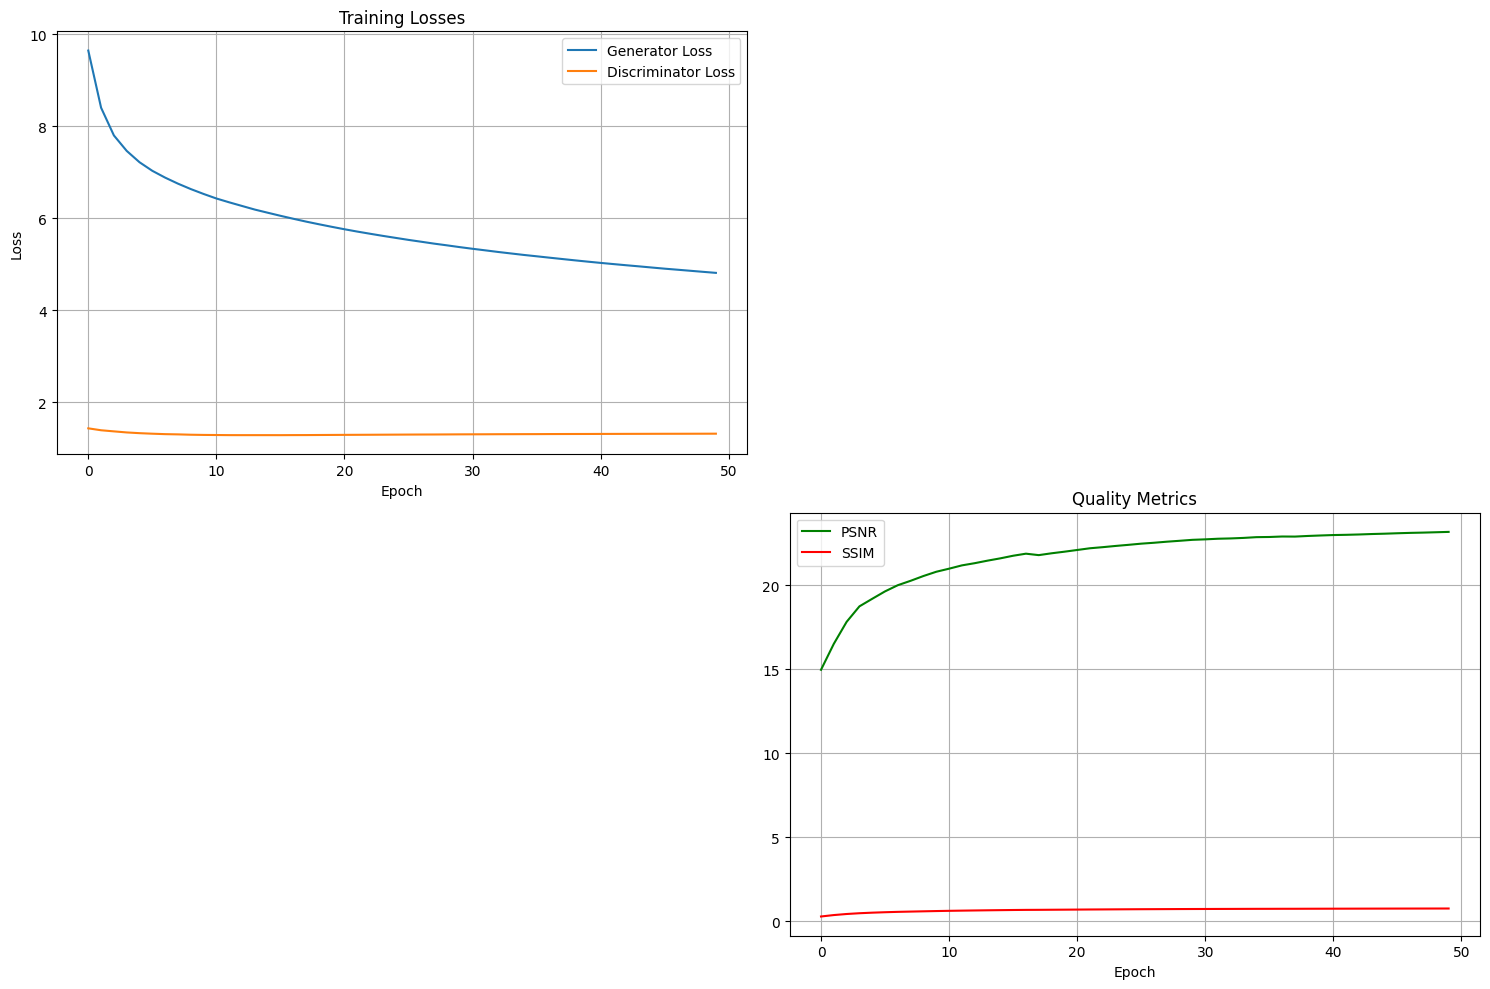

In [ ]:
plt.figure(figsize=(15, 10))
# Plot Generator and Discriminator Loss
plt.subplot(2, 2, 1)
plt.plot(history['gen_loss'], label='Generator Loss')
plt.plot(history['disc_loss'], label='Discriminator Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# PSNR and SSIM
plt.subplot(2, 2, 4)
plt.plot(history['psnr'], 'g-', label='PSNR')
plt.plot(history['ssim'], 'r-', label='SSIM')
plt.title('Quality Metrics')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
# Final evaluation
print("\nFinal evaluation on validation set...")

final_psnr, final_ssim = evaluate_model(generator, val_ds, num_samples=len(val_dataset))
print(f"Final PSNR: {final_psnr:.2f}, Final SSIM: {final_ssim:.4f}")


Final evaluation on validation set...
Final PSNR: 25.57, Final SSIM: 0.7970


In [ ]:
cgan.test_single_image("/content/14.jpg")


UnboundLocalError: cannot access local variable 'image' where it is not associated with a value

In [ ]:
cgan.save_model("my_deraining_model_final")

import pickle
with open("training_history.pkl", "wb") as f:
    pickle.dump(history, f)


Models saved to my_deraining_model_final


In [ ]:
%cp -r /content/training_results /content/drive/MyDrive/CGAN_Results/Final_output_Images

In [ ]:
%cp -r /content/logs /content/drive/MyDrive/CGAN_Results

In [ ]:
%cp -r /content/training_checkpoints /content/drive/MyDrive/CGAN_Results

^C


In [ ]:
%cp -r /content/training_metrics.png /content/drive/MyDrive/CGAN_Results

In [ ]:
%cp -r /content/my_deraining_model_final /content/drive/MyDrive/CGAN_Results

In [ ]:
%cp -r /content/training_history.pkl /content/drive/MyDrive/CGAN_Results

In [ ]:
%cp -r /content/my_deraining_model_epoch_10 /content/drive/MyDrive/CGAN_Results


In [ ]:
%cp -r /content/my_deraining_model_epoch_20 /content/drive/MyDrive/CGAN_Results


In [ ]:
%cp -r /content/my_deraining_model_epoch_30 /content/drive/MyDrive/CGAN_Results


In [ ]:
%cp -r /content/my_deraining_model_epoch_40 /content/drive/MyDrive/CGAN_Results


In [ ]:
%cp -r /content/my_deraining_model_epoch_50 /content/drive/MyDrive/CGAN_Results